# Character-level text generation with LSTM
**Description:** Generate text from Nietzsche's writings with a character-level LSTM.

## Setup


In [7]:
# import libraries
import random
import io

from GenerativeNotToxic import GenerativeTweet
import mysql.connector

from tensorflow import keras
from tensorflow.keras import layers

from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model

import pandas as pd
import numpy as np
import re


In [9]:
# read the data set
tweets = pd.read_csv('NoToxicTweets.csv')
tweets.drop(columns = ['toxic'], inplace = True)

In [10]:
path = 'vocabulary.txt'

In [11]:
# convert all tweets in lines
with open(path, 'w') as file:
    for tweet in tweets.pure_tweet:
        file.write(f'{tweet}\n')
    file.close()

In [8]:
!cat vocabulary.txt  | head -n 10

guys people in sweden are now inserting microchips in their hands with their covid passports on it they scan their
defense secretary lloyd austin has rejected oklahomas request to exempt the states national guard members from the pent
antivaccine christian broadcaster marcus lamb dies at age after contracting covid
federal judge blocks bidens covid vaccine mandate for health care workers
so having covid after vax is acceptable but covid unvaxxed is not socially acceptable
covid is the first thing lebrons ever got from china that wasnt made by slaves
lebron james has entered the nbas coronavirus health and safety protocols it is unclear whether he has tested positive for c
we all owe south africa a thank you and an apology
so does the covid vaccine
never forget droz pushed for hydroxycholoquine as a cureall for covid which it is not he helped keep the medicat


## Prepare the data


In [9]:


with io.open(path, encoding="utf-8") as f:
    text = f.read().lower()
text = text.replace("\n", " ")  # We remove newlines chars for nicer display
print("Corpus length:", len(text))

chars = sorted(list(set(text)))
print("Total chars:", len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

# cut the text in semi-redundant sequences of maxlen characters
maxlen = 100
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i : i + maxlen])
    next_chars.append(text[i + maxlen])
print("Number of sequences:", len(sentences))

x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1



Corpus length: 176357
Total chars: 27
Number of sequences: 58753


## Build the model: a single LSTM layer


In [10]:
# build the model
model = keras.Sequential(
    [
        keras.Input(shape=(maxlen, len(chars))),
        layers.LSTM(128),
        layers.Dropout(0.5),
        layers.Dense(len(chars), activation="softmax"),
    ]
)

## Prepare the text sampling function


In [11]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype("float64")
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)



## Train the model


In [12]:
ML_VERSION = "v1"

In [13]:
model = load_model(f"tweets.{ML_VERSION}.modelgenerative.hdf5")

In [14]:
epochs = 2
batch_size = 1024


optimizer = keras.optimizers.RMSprop(learning_rate=0.0001)
#model.compile(loss="categorical_crossentropy", optimizer=optimizer)
# Run training
model.compile(optimizer=optimizer, loss='categorical_crossentropy',
              metrics=['accuracy'], run_eagerly=True)
checkpointer = ModelCheckpoint(filepath=f"tweets.{ML_VERSION}.modelgenerative.hdf5", monitor='loss', verbose=1, save_best_only=True, mode='min')
model.fit(x, y, batch_size=batch_size, epochs=epochs, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/2
46/46 [==============================] - ETA: 0s - loss: 2.2425 - accuracy: 0.3365
Epoch 00001: loss improved from inf to 2.24246, saving model to /content/drive/MyDrive/tweets.v1.modelgenerative.hdf5
46/46 [==============================] - 99s 2s/step - loss: 2.2425 - accuracy: 0.3365 - val_loss: 2.2059 - val_accuracy: 0.3403
Epoch 2/2
46/46 [==============================] - ETA: 0s - loss: 2.2394 - accuracy: 0.3361
Epoch 00002: loss improved from 2.24246 to 2.23942, saving model to /content/drive/MyDrive/tweets.v1.modelgenerative.hdf5
46/46 [==============================] - 101s 2s/step - loss: 2.2394 - accuracy: 0.3361 - val_loss: 2.2056 - val_accuracy: 0.3386


In [15]:
def generate(model, sentence, diversity):
    generated = ""
    for i in range(100):
        x_pred = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(sentence):
            x_pred[0, t, char_indices[char]] = 1.0
        preds = model.predict(x_pred, verbose=0)[0]
        next_index = sample(preds, diversity)
        next_char = indices_char[next_index]
        sentence = sentence[1:] + next_char
        generated += next_char

    return generated

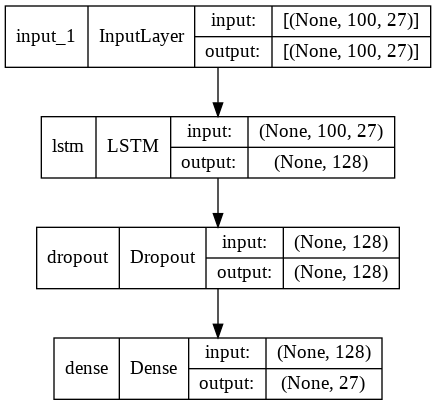

In [ ]:
plot_model(model, to_file="model_plot.png", show_shapes=True, show_layer_names=True)

In [17]:
text = "fuck you bitch"
#print(len(text))
generate(model, text, 1.5)



'ylamvdwtbhupdjwffkpqqxxwmmeelzzgroneacrlpszuojpnociyhosinrswongldpmpjh  tiqudmuujdlyldnkkmxsmnjgneaf'